In [8]:
# Imports
import sys
sys.path.append("../")
from src import get_worst_instance
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Ranges for gamma
GAMMAS = np.linspace(0, 2, 100)

# Constants
Ts = [1, 2, 5]
mu = 0
L = 1

rate_theory = lambda gamma, T: min(
    2 * ((1 - 1 / T) * gamma + 1 / T),
    2 / sum((gamma - 1) ** (2 * i) for i in range(T))
)

# Shorthands for the functions
get_rate = lambda gamma, T: get_worst_instance(gamma, T, mu, L, objective="bias")
get_variance = lambda gamma, T: get_worst_instance(gamma, T, mu, L, objective="variance")

# Pre-Compute all instances
# rates = [[get_rate(gamma, T) for gamma in tqdm(GAMMAS)] for T in Ts]
variances = [[get_variance(gamma, T) for gamma in tqdm(GAMMAS)] for T in Ts]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

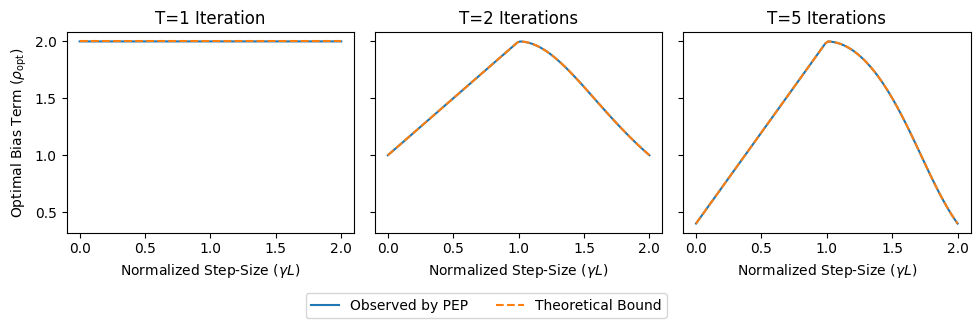

In [7]:
# Plot result with theoretical overlay for rates
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for i, (T, instances, ax) in enumerate(zip(Ts, rates, axs.flatten())):
    # Plot empirical results
    ax.plot(GAMMAS, [r.param.bias.value if r else None for r in instances], label="Observed by PEP")

    # Plot theoretical bound
    ax.plot(GAMMAS, [rate_theory(gamma, T) for gamma in GAMMAS], "--", label="Theoretical Bound")

    # Axis metadata
    ax.set_title(f"T={T} Iteration{'s' if T > 1 else ''}")
    ax.set_xlabel(r"Normalized Step-Size ($\gamma L$)")
    if i == 0: ax.set_ylabel(r"Optimal Bias ($\rho_{\text{opt}}$)")

# Get and show legend
handles, labels = axs.flatten()[0].get_legend_handles_labels()
plt.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.show()

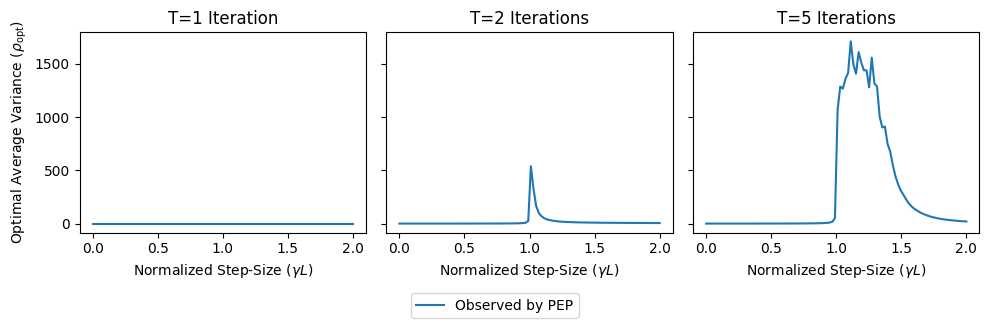

In [9]:
# Plot result with theoretical overlay for rates
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for i, (T, instances, ax) in enumerate(zip(Ts, variances, axs.flatten())):
    # Plot empirical results
    ax.plot(GAMMAS, [r.param.variance_avg.value if r else None for r in instances], label="Observed by PEP")

    # Plot theoretical bound
    # ax.plot(GAMMAS, [rate_theory(gamma, T) for gamma in GAMMAS], "--", label="Theoretical Bound")

    # Axis metadata
    ax.set_title(f"T={T} Iteration{'s' if T > 1 else ''}")
    ax.set_xlabel(r"Normalized Step-Size ($\gamma L$)")
    if i == 0: ax.set_ylabel(r"Optimal Average Variance ($\rho_{\text{opt}}$)")

# Get and show legend
handles, labels = axs.flatten()[0].get_legend_handles_labels()
plt.tight_layout()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.show()